In [1]:
"""
回归模型测试 & 回测
策略：当预测涨跌幅 > threshold 时买入（隐含持有5天后卖出）
与 test.ipynb 保持一致的简化逻辑
"""
use_gpu = True

# 模型路径（请根据实际训练结果修改）
model_path = "../pt/regression_baseline/best.pt"  # 修改为你的模型路径

# 预测收益率阈值（只有预测涨幅 > threshold 时才买入）
threshold = 0.01  # 1%

# 目标变量（需要与训练时一致）
# 使用 Ret_5d 作为真实收益率（5天收益）
target_col = "Ret_5d"

# 存储测试结果
test_results = {}

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}

## Load Test Data

In [3]:
# 测试数据：2001-2019
year_list = np.arange(2001, 2020, 1)

images = []
label_df = []
for year in year_list:
    images.append(np.memmap(os.path.join("../data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("../data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df).reset_index(drop=True)

print(f"Test data shape: {images.shape}")
print(f"Label shape: {label_df.shape}")
print(f"\nLabel columns: {label_df.columns.tolist()}")

Test data shape: (1403975, 64, 60)
Label shape: (1403975, 8)

Label columns: ['Date', 'StockID', 'MarketCap', 'Ret_5d', 'Ret_20d', 'Ret_60d', 'Ret_month', 'EWMA_vol']


In [4]:
# 获取真实收益率
true_returns = label_df[target_col].values

# 检查 NaN
nan_count = np.isnan(true_returns).sum()
print(f"Target: {target_col}")
print(f"  NaN count: {nan_count} ({nan_count/len(true_returns)*100:.2f}%)")

# 过滤 NaN
if nan_count > 0:
    valid_mask = ~np.isnan(true_returns)
    true_returns = true_returns[valid_mask]
    images = images[valid_mask]
    label_df = label_df[valid_mask].reset_index(drop=True)
    print(f"  After filtering: {len(true_returns)} samples")

print(f"\nTrue returns statistics:")
print(f"  Mean: {true_returns.mean():.6f}")
print(f"  Std:  {true_returns.std():.6f}")
print(f"  Min:  {true_returns.min():.6f}")
print(f"  Max:  {true_returns.max():.6f}")

Target: Ret_5d
  NaN count: 4042 (0.29%)
  After filtering: 1399933 samples

True returns statistics:
  Mean: 0.001572
  Std:  0.090173
  Min:  -0.954808
  Max:  14.427766


## Build Dataset

In [5]:
class RegressionDataset(Dataset):
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label).float()
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [6]:
dataset = RegressionDataset(images, true_returns)
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)
print(f"Test batches: {len(test_dataloader)}")

Test batches: 684


## Load Model & Inference

In [7]:
device = 'cuda' if use_gpu else 'cpu'
print(f"Using device: {device}")

# 检查模型文件
if not os.path.exists(model_path):
    print(f"Warning: Model not found: {model_path}")
    print("\nAvailable regression models:")
    pt_dir = "../pt"
    for d in os.listdir(pt_dir):
        if d.startswith("regression"):
            full_path = os.path.join(pt_dir, d)
            if os.path.isdir(full_path):
                best_pt = os.path.join(full_path, "best.pt")
                if os.path.exists(best_pt):
                    print(f"  - {best_pt}")
else:
    print(f"Model found: {model_path}")

Using device: cuda
Model found: ../pt/regression_baseline/best.pt


In [8]:
# 加载模型
net = torch.load(model_path, weights_only=False)
net = net.to(device)
net.eval()

# 统计参数量
if hasattr(net, 'module'):
    num_params = sum(p.numel() for p in net.module.parameters())
else:
    num_params = sum(p.numel() for p in net.parameters())
print(f"Model parameters: {num_params:,} ({num_params/1e6:.2f}M)")

Model parameters: 24,243,073 (24.24M)


In [9]:
# 推理
all_predictions = []
all_targets = []

with torch.no_grad():
    with tqdm(test_dataloader, desc="Inference") as t:
        for X, y in t:
            X = X.to(device)
            y_pred = net(X)
            all_predictions.append(y_pred.cpu())
            all_targets.append(y)

predictions = torch.cat(all_predictions).numpy()
targets = torch.cat(all_targets).numpy()

print(f"\nPredictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

Inference: 100%|██████████| 684/684 [00:43<00:00, 15.84it/s]


Predictions shape: (1399933,)
Targets shape: (1399933,)


## Evaluate Predictions

In [10]:
# 计算回归指标
mse = np.mean((predictions - targets) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - targets))
correlation = np.corrcoef(predictions, targets)[0, 1]

# 方向准确率（预测涨跌方向是否正确）
direction_correct = ((predictions > 0) == (targets > 0)).mean()

print("="*60)
print("Regression Metrics")
print("="*60)
print(f"MSE:         {mse:.6f}")
print(f"RMSE:        {rmse:.6f}")
print(f"MAE:         {mae:.6f}")
print(f"Correlation: {correlation:.4f}")
print(f"Direction Accuracy: {direction_correct:.4f} ({direction_correct*100:.2f}%)")

Regression Metrics
MSE:         0.008229
RMSE:        0.090714
MAE:         0.050128
Correlation: 0.0560
Direction Accuracy: 0.5287 (52.87%)


In [11]:
# 预测值分布
print("\nPrediction statistics:")
print(f"  Mean: {predictions.mean():.6f}")
print(f"  Std:  {predictions.std():.6f}")
print(f"  Min:  {predictions.min():.6f}")
print(f"  Max:  {predictions.max():.6f}")

# 阈值筛选统计
long_mask = predictions > threshold
short_mask = predictions < -threshold
hold_mask = ~long_mask & ~short_mask

print(f"\nThreshold: {threshold} ({threshold*100:.1f}%)")
print(f"  Long signals (pred > {threshold}):  {long_mask.sum():,} ({long_mask.mean()*100:.2f}%)")
print(f"  Short signals (pred < -{threshold}): {short_mask.sum():,} ({short_mask.mean()*100:.2f}%)")
print(f"  Hold (no action):                   {hold_mask.sum():,} ({hold_mask.mean()*100:.2f}%)")


Prediction statistics:
  Mean: 0.008263
  Std:  0.013916
  Min:  -0.087922
  Max:  0.289701

Threshold: 0.01 (1.0%)
  Long signals (pred > 0.01):  551,651 (39.41%)
  Short signals (pred < -0.01): 76,477 (5.46%)
  Hold (no action):                   771,805 (55.13%)


## Backtesting Strategy

In [12]:
# 将预测结果添加到 label_df
label_df['pred_return'] = predictions
label_df['true_return'] = targets

# 简化策略：只做多（与 test.ipynb 一致）
# 当预测涨幅 > threshold 时买入，隐含持有5天后卖出
selected_mask = predictions > threshold
num_selected = selected_mask.sum()
selection_ratio = num_selected / len(predictions) * 100

print(f"Threshold: {threshold} ({threshold*100:.1f}%)")
print(f"Selected stocks: {num_selected:,} ({selection_ratio:.2f}%)")

Threshold: 0.01 (1.0%)
Selected stocks: 551,651 (39.41%)


In [13]:
def calculate_strategy_returns(label_df, predict_return, threshold):
    """
    计算策略收益（与 test.ipynb 一致的简化逻辑）
    
    策略：
    - Baseline: 每日等权买入所有股票，持有5天
    - Strategy: 只买入预测涨幅 > threshold 的股票，持有5天
    
    Returns:
        ret_baseline: 基准收益（买入所有股票）
        ret_strategy: 策略收益（根据模型选股）
    """
    # Baseline: 每日所有股票的平均5日收益
    ret_baseline = label_df.groupby('Date')[target_col].mean()
    
    # Strategy: 只买入预测涨幅 > threshold 的股票
    mask = predict_return > threshold
    label_filtered = label_df[mask]
    
    if len(label_filtered) > 0:
        ret_strategy = label_filtered.groupby('Date')[target_col].mean()
    else:
        ret_strategy = pd.Series(dtype=float)
    
    return ret_baseline, ret_strategy

In [14]:
# 计算策略收益（与 test.ipynb 一致）
ret_baseline, ret_strategy = calculate_strategy_returns(label_df, predictions, threshold)

# 累计收益
cum_baseline = (ret_baseline + 1).cumprod()
cum_strategy = (ret_strategy + 1).cumprod() if len(ret_strategy) > 0 else pd.Series([1.0])

# 最终累计收益
cum_ret_baseline = cum_baseline.iloc[-1] if len(cum_baseline) > 0 else 1.0
cum_ret_strategy = cum_strategy.iloc[-1] if len(cum_strategy) > 0 else 1.0
excess_return = cum_ret_strategy - cum_ret_baseline

print("="*60)
print("Backtesting Results (5-day holding period)")
print("="*60)
print(f"\nThreshold: {threshold} ({threshold*100:.1f}%)")
print(f"Selected: {num_selected:,} stocks ({selection_ratio:.2f}%)")
print(f"\nCumulative Returns:")
print(f"  Baseline (Buy All):  {cum_ret_baseline:.4f}x")
print(f"  Strategy:            {cum_ret_strategy:.4f}x")
print(f"  Excess Return:       {excess_return:+.4f}")

Backtesting Results (5-day holding period)

Threshold: 0.01 (1.0%)
Selected: 551,651 stocks (39.41%)

Cumulative Returns:
  Baseline (Buy All):  1.3496x
  Strategy:            4.4640x
  Excess Return:       +3.1144


In [15]:
# 计算年化收益率（可选）
n_years = (pd.to_datetime(ret_baseline.index[-1]) - pd.to_datetime(ret_baseline.index[0])).days / 365

ann_baseline = cum_ret_baseline ** (1/n_years) - 1 if cum_ret_baseline > 0 else 0
ann_strategy = cum_ret_strategy ** (1/n_years) - 1 if cum_ret_strategy > 0 else 0

print(f"\nAnnualized Returns ({n_years:.1f} years):")
print(f"  Baseline:  {ann_baseline*100:.2f}%")
print(f"  Strategy:  {ann_strategy*100:.2f}%")


Annualized Returns (18.9 years):
  Baseline:  1.60%
  Strategy:  8.23%


## Visualization

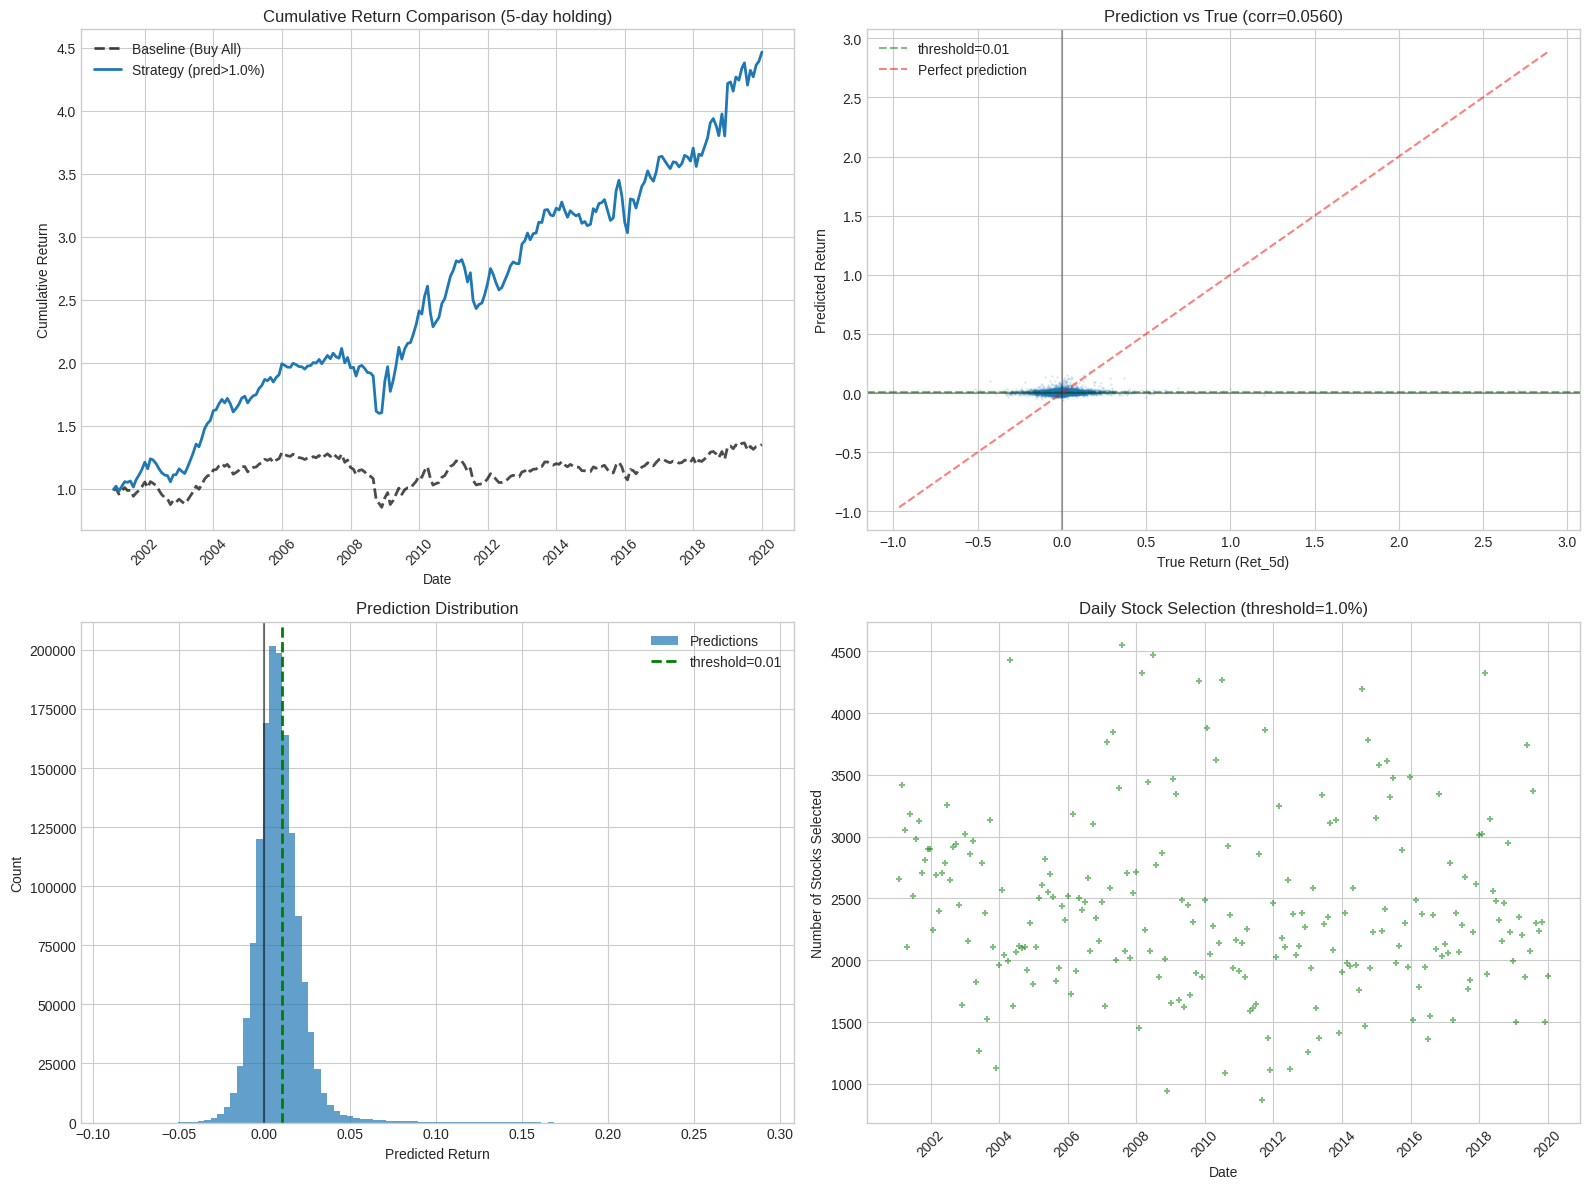


Plot saved to: ../pic/test_regression_comparison.png


In [16]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 累计收益对比（与 test.ipynb 一致）
ax1 = axes[0, 0]
ax1.plot(cum_baseline.index, cum_baseline.values, 'k--', label='Baseline (Buy All)', linewidth=2, alpha=0.7)
if len(cum_strategy) > 1:
    ax1.plot(cum_strategy.index, cum_strategy.values, label=f'Strategy (pred>{threshold*100:.1f}%)', linewidth=2, color='#1f77b4')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.set_title(f'Cumulative Return Comparison (5-day holding)')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2. 预测值 vs 真实值散点图
ax2 = axes[0, 1]
sample_idx = np.random.choice(len(predictions), min(10000, len(predictions)), replace=False)
ax2.scatter(targets[sample_idx], predictions[sample_idx], alpha=0.1, s=1)
ax2.axhline(y=threshold, color='g', linestyle='--', alpha=0.5, label=f'threshold={threshold}')
ax2.axvline(x=0, color='k', linestyle='-', alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
lims = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]), max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims, lims, 'r--', alpha=0.5, label='Perfect prediction')
ax2.set_xlabel('True Return (Ret_5d)')
ax2.set_ylabel('Predicted Return')
ax2.set_title(f'Prediction vs True (corr={correlation:.4f})')
ax2.legend()

# 3. 预测值分布
ax3 = axes[1, 0]
ax3.hist(predictions, bins=100, alpha=0.7, label='Predictions', color='#1f77b4')
ax3.axvline(x=threshold, color='g', linestyle='--', linewidth=2, label=f'threshold={threshold}')
ax3.axvline(x=0, color='k', linestyle='-', alpha=0.5)
ax3.set_xlabel('Predicted Return')
ax3.set_ylabel('Count')
ax3.set_title('Prediction Distribution')
ax3.legend()

# 4. 每日选股数量（与 test.ipynb 一致）
ax4 = axes[1, 1]
label_df_selected = label_df[predictions > threshold]
stocks_per_date = label_df_selected.groupby('Date').size()
ax4.scatter(stocks_per_date.index, stocks_per_date.values, marker='+', alpha=0.5, s=20, color='green')
ax4.set_xlabel('Date')
ax4.set_ylabel('Number of Stocks Selected')
ax4.set_title(f'Daily Stock Selection (threshold={threshold*100:.1f}%)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../pic/test_regression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: ../pic/test_regression_comparison.png")

## Different Thresholds Comparison

In [17]:
# 测试不同阈值的效果（与 test.ipynb 一致的逻辑）
thresholds_to_test = [0.005, 0.01, 0.02, 0.03, 0.05]
results_by_threshold = []

for th in thresholds_to_test:
    # 计算收益
    ret_bl, ret_st = calculate_strategy_returns(label_df, predictions, th)
    
    cum_baseline_final = (ret_bl + 1).cumprod().iloc[-1]
    cum_strategy_final = (ret_st + 1).cumprod().iloc[-1] if len(ret_st) > 0 else 1.0
    
    # 选股比例
    select_ratio = (predictions > th).mean() * 100
    
    results_by_threshold.append({
        'threshold': th,
        'selection_ratio': select_ratio,
        'cum_baseline': cum_baseline_final,
        'cum_strategy': cum_strategy_final,
        'excess_return': cum_strategy_final - cum_baseline_final,
    })

results_df = pd.DataFrame(results_by_threshold)
print("\n" + "="*80)
print("Results by Threshold")
print("="*80)
print(results_df.to_string(index=False))


Results by Threshold
 threshold  selection_ratio  cum_baseline  cum_strategy  excess_return
     0.005        58.506729      1.349571      2.925678       1.576107
     0.010        39.405529      1.349571      4.464006       3.114435
     0.020        14.150963      1.349571     12.412025      11.062454
     0.030         4.356066      1.349571     35.534229      34.184658
     0.050         1.092767      1.349571    124.267025     122.917455


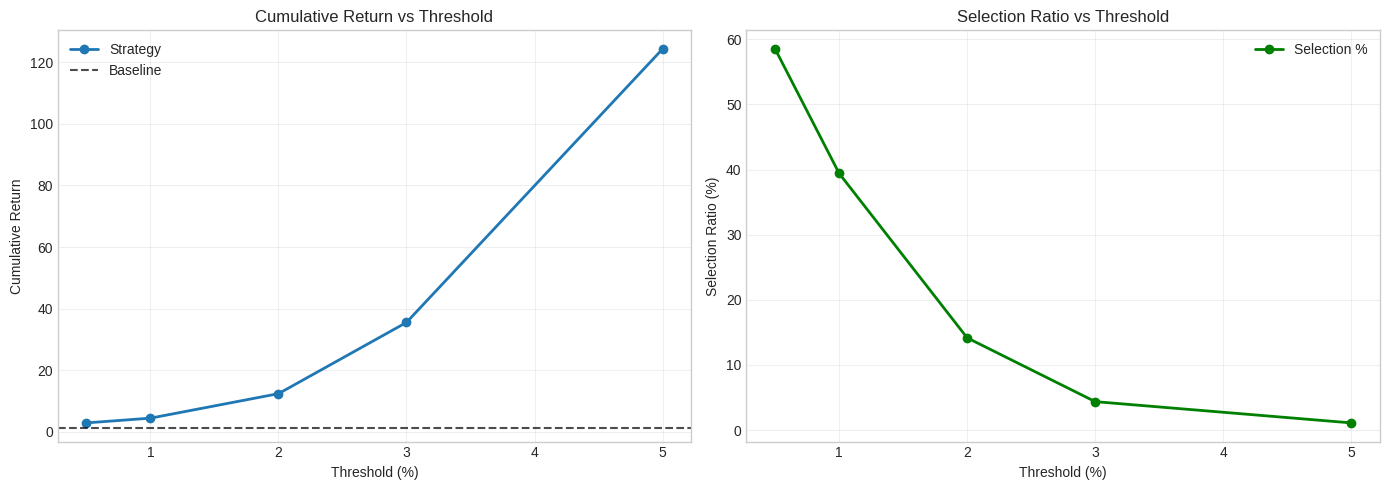


Plot saved to: ../pic/test_regression_thresholds.png


In [18]:
# 绘制不同阈值的效果
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 累计收益 vs 阈值
ax1 = axes[0]
ax1.plot(results_df['threshold']*100, results_df['cum_strategy'], 'o-', label='Strategy', linewidth=2, color='#1f77b4')
ax1.axhline(y=results_df['cum_baseline'].iloc[0], color='k', linestyle='--', label='Baseline', alpha=0.7)
ax1.set_xlabel('Threshold (%)')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('Cumulative Return vs Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 选股比例 vs 阈值
ax2 = axes[1]
ax2.plot(results_df['threshold']*100, results_df['selection_ratio'], 'o-', label='Selection %', linewidth=2, color='green')
ax2.set_xlabel('Threshold (%)')
ax2.set_ylabel('Selection Ratio (%)')
ax2.set_title('Selection Ratio vs Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../pic/test_regression_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: ../pic/test_regression_thresholds.png")

## Save Results

In [19]:
import json

# 保存结果（与 test.ipynb 格式一致）
test_results = {
    'model_path': model_path,
    'target_col': target_col,
    'threshold': threshold,
    'num_samples': len(predictions),
    'num_selected': int(num_selected),
    'selection_ratio': float(selection_ratio),
    'metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'correlation': float(correlation),
        'direction_accuracy': float(direction_correct),
    },
    'backtesting': {
        'cum_baseline': float(cum_ret_baseline),
        'cum_strategy': float(cum_ret_strategy),
        'excess_return': float(excess_return),
    },
    'threshold_comparison': results_df.to_dict('records'),
}

with open('../pt/test_regression_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print("Results saved to: ../pt/test_regression_results.json")

Results saved to: ../pt/test_regression_results.json


In [20]:
# 打印最终总结（与 test.ipynb 格式一致）
print("\n" + "="*70)
print("REGRESSION MODEL TEST SUMMARY")
print("="*70)
print(f"\nModel: {model_path}")
print(f"Target: {target_col} (5-day return)")
print(f"Test samples: {len(predictions):,}")
print(f"\nRegression Metrics:")
print(f"  MSE:         {mse:.6f}")
print(f"  RMSE:        {rmse:.6f}")
print(f"  MAE:         {mae:.6f}")
print(f"  Correlation: {correlation:.4f}")
print(f"  Direction Accuracy: {direction_correct*100:.2f}%")
print(f"\nBacktesting (threshold={threshold*100:.1f}%, 5-day holding):")
print(f"  Selected Stocks: {num_selected:,} ({selection_ratio:.2f}%)")
print(f"  Baseline (Buy All): {cum_ret_baseline:.4f}x")
print(f"  Strategy:           {cum_ret_strategy:.4f}x")
print(f"  Excess Return:      {excess_return:+.4f}")
print("\n" + "="*70)


REGRESSION MODEL TEST SUMMARY

Model: ../pt/regression_baseline/best.pt
Target: Ret_5d (5-day return)
Test samples: 1,399,933

Regression Metrics:
  MSE:         0.008229
  RMSE:        0.090714
  MAE:         0.050128
  Correlation: 0.0560
  Direction Accuracy: 52.87%

Backtesting (threshold=1.0%, 5-day holding):
  Selected Stocks: 551,651 (39.41%)
  Baseline (Buy All): 1.3496x
  Strategy:           4.4640x
  Excess Return:      +3.1144

